# Installs

In [1]:
pip install earthpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 76.8 MB/s eta 0:00:00


In [2]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 67.9 MB/s eta 0:00:00


In [3]:
pip install pyhdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.6/771.6 kB 31.8 MB/s eta 0:00:00


In [4]:
pip install polars

# Packages

In [95]:
import os
import warnings
import datetime
import pytz
import re
import pickle
import functools
from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import numpy as np
import pandas as pd
import numpy.ma as ma
import polars as pl
from shapely.geometry import mapping, box
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

from pyhdf.SD import SD, SDC

import dask.array as da

import pyproj
import re

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import polars as pl
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from tqdm import tqdm
## https://hdfeos.org/software/pyhdf.php
warnings.simplefilter('ignore')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
import sys
sys.path.append('/content/drive/MyDrive/lpg_analysis')
from model import (
    get_dates_pl,
    process_data,
    get_fourier_components,
    plot_contour,
    get_joint_distribution,
    get_piecewise_contribution,
    y_distribution,
    get_piecewise_posterior,
    run_chain,
    get_post,
)

# Data

## propane

In [157]:
"""
shape = (n_blocks_per_row, n_blocks_per_row, n_timeperiods, n_vars, n_changepoints) # after axis swap
shape = (120, 120, 560, 6)
axis 3 metric order ['qa', 'std', 'mean', 'percentile_10', 'median', 'percentile_90']
# ndvi valid range -2000 to 10000, fill value = -3000
"""
cities = pd.read_csv("/content/drive/MyDrive/propane/cities.csv").values

# data is monthly
propane = (
    pl.from_pandas(pd.read_csv('/content/drive/MyDrive/propane/demand_residential_monthly.csv'))
    .with_columns(
        period_start = pl.col('period_start').str.to_date(format='%m/%d/%Y'),
        period_ahead_2 = pl.col('period_ahead_2').str.to_date(format='%m/%d/%Y'),
        period_ahead_4 = pl.col('period_ahead_4').str.to_date(format='%m/%d/%Y'),
    )
    # .filter(~pl.col('period_ahead_4').is_null())
)
print(f"propane.shape: {propane.shape}")
propane.head(5)

propane.shape: (114, 6)


year,month,period_start,period_ahead_2,period_ahead_4,demand
i64,i64,date,date,date,f64
2015,1,2015-01-01,2015-03-01,2015-05-01,23.84107
2015,2,2015-02-01,2015-04-01,2015-06-01,23.62496
2015,3,2015-03-01,2015-05-01,2015-07-01,24.963921
2015,4,2015-04-01,2015-06-01,2015-08-01,24.422148
2015,5,2015-05-01,2015-07-01,2015-09-01,26.013106


## dates

In [158]:
with open('/content/drive/MyDrive/propane/data_agg/dates.pickle', 'rb') as f:
    dates = np.array(pickle.load(f))
print(f"dates.min(): {dates.min()}, dates.max(): {dates.max()}")
print(f"dates.shape before mask: {dates.shape}")

# filter satellite dates to match where we have demand data with the lags
mask_dates = (
    (pd.to_datetime(dates) >= pd.to_datetime(propane['period_ahead_4'].min()))
    &
    (pd.to_datetime(dates) <= pd.to_datetime(propane['period_ahead_4'].max()))
)
dates = dates[mask_dates]
print(f"dates.shape after mask: {dates.shape}")

dates_pl, year_months = get_dates_pl(dates=dates)
print(f"dates_pl.shape: {dates_pl.shape}")
print(f"year_months.shape: {year_months.shape}")
dates_pl.head()

dates.min(): 2000-02-18 00:00:00, dates.max(): 2024-05-24 00:00:00
dates.shape before mask: (560,)
dates.shape after mask: (210,)
dates_pl.shape: (210, 5)
year_months.shape: (109,)


date,year,month,day,year_month
datetime[ns],i32,str,str,date
2015-05-09 00:00:00,2015,"""05""","""01""",2015-05-01
2015-05-25 00:00:00,2015,"""05""","""01""",2015-05-01
2015-06-10 00:00:00,2015,"""06""","""01""",2015-06-01
2015-06-26 00:00:00,2015,"""06""","""01""",2015-06-01
2015-07-12 00:00:00,2015,"""07""","""01""",2015-07-01


## ndvi

In [159]:
metrics_idx = {'qa':0, 'stddev':1, 'mean':2, 'percentile_10':3, 'median':4, 'percentile_90':5}
path = '/content/drive/MyDrive/propane/data_agg/ndvi_qa.pickle'
with open(path, 'rb') as f:
    ndvi = pickle.load(f).astype(np.int16)
    ndvi = ndvi.swapaxes(2, 3)[..., np.newaxis]
    ndvi = ndvi[:, :, mask_dates, :, :]

print(f"ndvi.shape before monthly averaging: {ndvi.shape}")

#----------------------------------------------------------------------
# Average across multiple observations per month to get monthly data
#----------------------------------------------------------------------
storage_dates = np.array([year_months[0]])
mask = dates_pl['year_month'].to_numpy() == year_months[0]

storage_ndvi = ndvi[:, :, mask, :, :].mean(axis=2, keepdims=True)
for year_month in year_months[1:]:
    storage_dates = np.concatenate(
        [
            storage_dates,
            np.array([year_month]),
            ]
        )
    mask = dates_pl['year_month'].to_numpy() == year_month

    storage_ndvi = np.concatenate(
        [
            storage_ndvi,
            ndvi[:, :, mask, :, :].mean(axis=2, keepdims=True),
            ],
        axis=2,
        )

ndvi = storage_ndvi
dates = storage_dates
dates_pl, year_months = get_dates_pl(dates=dates)

print(f"storage_ndvi.shape: {storage_ndvi.shape}")
print(f"storage_dates.shape: {storage_dates.shape}")
print(f"ndvi.shape: {ndvi.shape}")
print(f"dates.shape: {len(dates):}")
print(f"dates.min(): {dates.min()}, dates.max(): {dates.max()}")
print(f"dates_pl.shape: {dates_pl.shape}")
print(f"year_months.shape: {year_months.shape}")
# propane

ndvi.shape before monthly averaging: (120, 120, 210, 6, 1)
storage_ndvi.shape: (120, 120, 109, 6, 1)
storage_dates.shape: (109,)
ndvi.shape: (120, 120, 109, 6, 1)
dates.shape: 109
dates.min(): 2015-05-01, dates.max(): 2024-05-01
dates_pl.shape: (109, 5)
year_months.shape: (109,)


# Questions to answer

1. When propane demand is high, is ndvi also high?

# Data Prep

## y: ndvi

In [160]:
"""
Y: ndvi
X: fourier components, piecewise_vars = trend, clouds, rain, heat, propane
shape = (n_blocks_per_row, n_blocks_per_row, n_timeperiods, n_vars, n_changepoints)
"""
y_data = ndvi[:, :, :, [metrics_idx['mean']], :]

mu = y_data.mean(axis=2, keepdims=True)
sigma = y_data.std(axis=2, keepdims=True)
y_std = (y_data - mu) / sigma

# start_lat=52
# stop_lat=62
# start_lon=59
# stop_lon=69

start_lat=72
stop_lat=82
start_lon=79
stop_lon=89

plus_minus = 15
start_lat = start_lat - plus_minus
stop_lat = stop_lat + plus_minus
start_lon = start_lon - plus_minus
stop_lon = stop_lon + plus_minus

y_std = y_std[start_lon:stop_lon, start_lat:stop_lat, :, :, :]

n_blocks_per_row = y_std.shape[0]

print(f"y_std.shape: {y_std.shape}")

y_std.shape: (40, 40, 109, 1, 1)


## X_fourier

In [161]:
X_fourier = get_fourier_components(
    n_timeperiods=len(dates),
    n_blocks_per_row=n_blocks_per_row,
    periodicity=12,
    n_components=4,
)
print(f"X_fourier.shape: {X_fourier.shape}")

X_fourier.shape: (40, 40, 109, 1, 8)


## X: trend

In [162]:
"""
Y: ndvi
X: fourier components, piecewise_vars = trend, clouds, rain, heat, propane
shape = (n_blocks_per_row, n_blocks_per_row, n_timeperiods, n_vars, n_changepoints)
"""
trend_linspace = np.linspace(start=0, stop=1, num=len(dates))[
    np.newaxis, np.newaxis, :, np.newaxis, np.newaxis
]


# X_trend = X_trend * np.ones(shape=(n_blocks_per_row,n_blocks_per_row,1,1,1))
changepoints_trend, I_trend, X_trend = process_data(
    data=trend_linspace,
    n_blocks_per_row=n_blocks_per_row,
    )

a=I_trend[0, 0, :, 0, :].sum(axis=1)
b=np.concatenate([a[1:], np.array([3]),])
mask_changepoint_dates = a-b == -1
changepoints_trend_dates = dates[mask_changepoint_dates]

print(f"changepoints_trend_dates: {changepoints_trend_dates.squeeze()}")

changepoints.shape: (1, 1, 1, 1, 3)
I_data.shape: (40, 40, 109, 1, 3)
X_std.shape: (40, 40, 109, 1, 1)
changepoints: [-8.58116330e-01  1.90540102e-16  8.58116330e-01]
changepoints_trend_dates: ['2017-08-01' '2019-11-01' '2022-02-01']


## X: clouds (i.e. "qa")


In [163]:
changepoints_clouds, I_clouds, X_clouds = process_data(
    data=ndvi[start_lon:stop_lon, start_lat:stop_lat, :, [metrics_idx['qa']], :],
    n_blocks_per_row=n_blocks_per_row,
    )

changepoints.shape: (1, 1, 1, 1, 3)
I_data.shape: (40, 40, 109, 1, 3)
X_std.shape: (40, 40, 109, 1, 1)
changepoints: [-0.80876931 -0.09631808  0.76863581]


## X: rain

In [164]:
"""
Y: ndvi
X: fourier components, piecewise_vars = trend, clouds, rain, heat, propane
shape = (n_blocks_per_row, n_blocks_per_row, n_timeperiods, n_vars, n_changepoints)
"""
rain = pl.from_pandas(pd.read_csv("/content/drive/MyDrive/propane/rain.csv")).with_columns(year = pl.col('year').cast(pl.Int32))
rain = (
    rain
    .join(
        other=dates_pl,
        on=['year'],
        how='inner',
    )
    ['rain']
    .to_numpy()[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]
)
print(f"rain.shape: {rain.shape}")

changepoints_rain, I_rain, X_rain = process_data(
    data=rain,
    n_blocks_per_row=n_blocks_per_row,
    )

rain.shape: (1, 1, 109, 1, 1)
changepoints.shape: (1, 1, 1, 1, 3)
I_data.shape: (40, 40, 109, 1, 3)
X_std.shape: (40, 40, 109, 1, 1)
changepoints: [-0.62475252 -0.09578196  0.62894851]


## X: heat

In [165]:
"""
Y: ndvi
X: fourier components, piecewise_vars = trend, clouds, rain, heat, propane
shape = (n_blocks_per_row, n_blocks_per_row, n_timeperiods, n_vars, n_changepoints)
"""
heat = pl.from_pandas(pd.read_csv("/content/drive/MyDrive/propane/heat.csv")).with_columns(year = pl.col('year').cast(pl.Int32))
heat = (
    heat
    .join(
        other=dates_pl,
        on=['year'],
        how='inner',
    )

)
# display(heat)
heat = (
    heat
    ['heat']
    .to_numpy()[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]
)
print(f"heat.shape: {heat.shape}")

changepoints_heat, I_heat, X_heat = process_data(
    data=heat,
    n_blocks_per_row=n_blocks_per_row
    )

heat.shape: (1, 1, 109, 1, 1)
changepoints.shape: (1, 1, 1, 1, 3)
I_data.shape: (40, 40, 109, 1, 3)
X_std.shape: (40, 40, 109, 1, 1)
changepoints: [-0.6670005   0.05193635  0.74374352]


## X: propane

### get_propane

In [166]:
def get_propane_ahead(col):
    propane_ahead = (
        propane
        .join(
            other=dates_pl.select(['year_month']),
            left_on=[col],
            right_on=['year_month'],
            how='inner',
        )
        ['demand']
        .to_numpy()[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]
    )
    return propane_ahead

In [167]:
"""
Y: ndvi
X: fourier components, piecewise_vars = trend, clouds, rain, heat, propane
shape = (n_blocks_per_row, n_blocks_per_row, n_timeperiods, n_vars, n_changepoints)
"""
propane_ahead_0 = get_propane_ahead('period_start')
propane_ahead_2 = get_propane_ahead('period_ahead_2')
propane_ahead_4 = get_propane_ahead('period_ahead_4')

print(f"propane_ahead_0.shape: {propane_ahead_0.shape}")
print(f"propane_ahead_2.shape: {propane_ahead_2.shape}")
print(f"propane_ahead_4.shape: {propane_ahead_4.shape}")

changepoints_propane_ahead_0, I_propane_ahead_0, X_propane_ahead_0 = process_data(
    data=propane_ahead_0,
    n_blocks_per_row=n_blocks_per_row,
    )

changepoints_propane_ahead_2, I_propane_ahead_2, X_propane_ahead_2 = process_data(
    data=propane_ahead_2,
    n_blocks_per_row=n_blocks_per_row,
    )

changepoints_propane_ahead_4, I_propane_ahead_4, X_propane_ahead_4 = process_data(
    data=propane_ahead_4,
    n_blocks_per_row=n_blocks_per_row,
    )

propane_ahead_0.shape: (1, 1, 109, 1, 1)
propane_ahead_2.shape: (1, 1, 109, 1, 1)
propane_ahead_4.shape: (1, 1, 109, 1, 1)
changepoints.shape: (1, 1, 1, 1, 3)
I_data.shape: (40, 40, 109, 1, 3)
X_std.shape: (40, 40, 109, 1, 1)
changepoints: [-0.83764638  0.15447173  0.73231534]
changepoints.shape: (1, 1, 1, 1, 3)
I_data.shape: (40, 40, 109, 1, 3)
X_std.shape: (40, 40, 109, 1, 1)
changepoints: [-0.80694307  0.14058762  0.76036703]
changepoints.shape: (1, 1, 1, 1, 3)
I_data.shape: (40, 40, 109, 1, 3)
X_std.shape: (40, 40, 109, 1, 1)
changepoints: [-0.78224209  0.07991387  0.78400343]


## X_data

In [168]:
print(f"X_trend.shape: {X_trend.shape}")
print(f"X_clouds.shape: {X_clouds.shape}")
# print(f"X_rain.shape: {X_rain.shape}")
# print(f"X_heat.shape: {X_heat.shape}")
print(f"X_propane_ahead_4.shape: {X_propane_ahead_4.shape}")
vars = [
    'trend',
    'clouds',
    # 'rain',
    # 'heat',
    # 'propane_ahead_0',
    # 'propane_ahead_2',
    'propane_ahead_4',
    ]
idx_2_var = {i:v for i,v in zip(np.arange(len(vars)), vars)}
var_2_idx = {v:i for v,i in zip(vars, np.arange(len(vars)),)}

X_data = np.concatenate(
    [
        X_trend,
        X_clouds,
        # X_rain,
        # X_heat,
        # X_propane_ahead_0,
        # X_propane_ahead_2,
        X_propane_ahead_4
    ],
    axis=3,
)
print(f"X_data.shape: {X_data.shape}")

changepoints = np.concatenate(
    [
        changepoints_trend,
        changepoints_clouds,
        # changepoints_rain,
        # changepoints_heat,
        # changepoints_propane_ahead_0,
        # changepoints_propane_ahead_2,
        changepoints_propane_ahead_4,
    ],
    axis=3,
)
print(f"changepoints.shape: {changepoints.shape}")

I_data = np.concatenate(
    [
        I_trend,
        I_clouds,
        # I_rain,
        # I_heat,
        # I_propane_ahead_0,
        # I_propane_ahead_2,
        I_propane_ahead_4,
    ],
    axis=3,
)
print(f"I_data.shape: {I_data.shape}")

X_trend.shape: (40, 40, 109, 1, 1)
X_clouds.shape: (40, 40, 109, 1, 1)
X_propane_ahead_4.shape: (40, 40, 109, 1, 1)
X_data.shape: (40, 40, 109, 3, 1)
changepoints.shape: (1, 1, 1, 3, 3)
I_data.shape: (40, 40, 109, 3, 3)


# EDA

mean_stddev.shape: (120, 120)


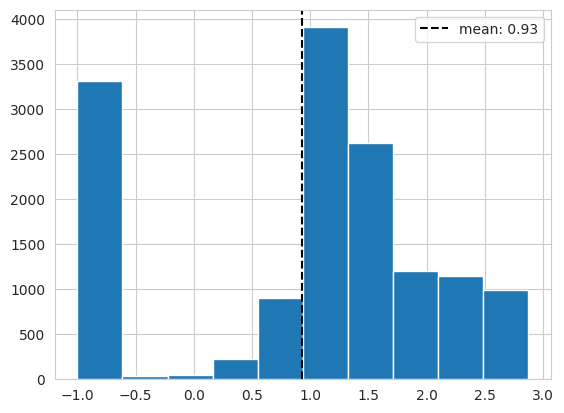

In [169]:
#--------------------------------------------------------------
# Quality
#--------------------------------------------------------------
"""
Quality
-1 - 0      Fill/No Data Not Processed
0  - 1      Good Data Use with confidence
1  - 0.5    Marginal data Useful, but look at other QA information
2  - 0      Snow/Ice Target covered with snow/ice
3  - 0      Cloudy Target not visible, covered with cloud

For the aggregation of qa data, I take the mean across the 10k block
"""
mean_qa = ndvi[:, :, :, metrics_idx['qa'], :].mean(axis=2).squeeze()
mean_stddev = ndvi[:, :, :, metrics_idx['stddev'], :].mean(axis=2).squeeze()
mean_mean = ndvi[:, :, :, metrics_idx['mean'], :].mean(axis=2).squeeze()
print(f"mean_stddev.shape: {mean_stddev.shape}")
plt.hist(mean_qa.flatten())
plt.axvline(mean_qa.mean(), ls='--', color='k', label=f"mean: {mean_qa.mean():.2f}")
plt.legend();

In [170]:
threshold_qa = 0.5
mask_qa = (mean_qa >= threshold_qa
           )
n_blocks = mask_qa.shape[0]*mask_qa.shape[1]
print(f"mask_qa.sum(): {mask_qa.sum():,} of {n_blocks:,}, {mask_qa.sum()/n_blocks:.2%}")

mask_qa.sum(): 10,836 of 14,400, 75.25%


<Axes: >

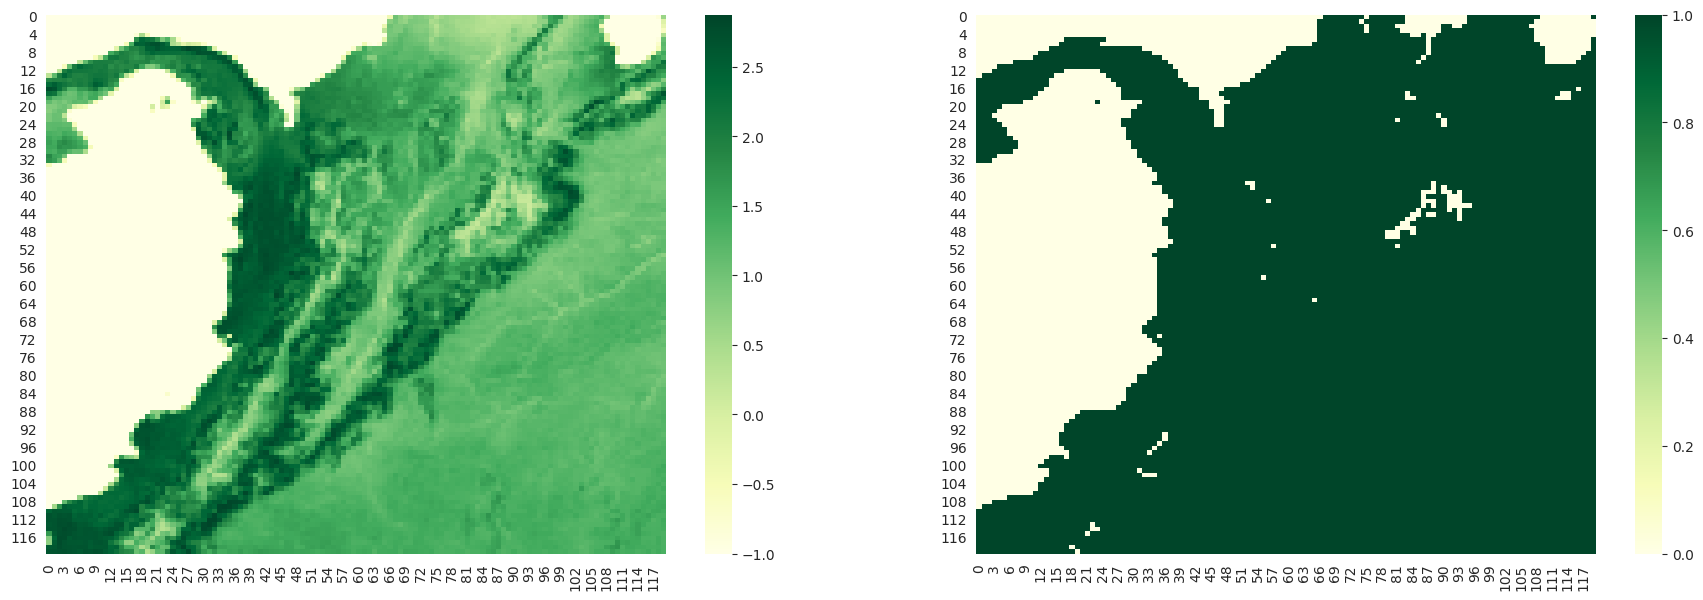

In [171]:
f, ax = plt.subplots(1,2, figsize=[22,7])
sns.heatmap(data=mean_qa, ax=ax[0], cmap='YlGn',)
sns.heatmap(data=mask_qa, ax=ax[1], cmap='YlGn',)

## map

<Axes: >

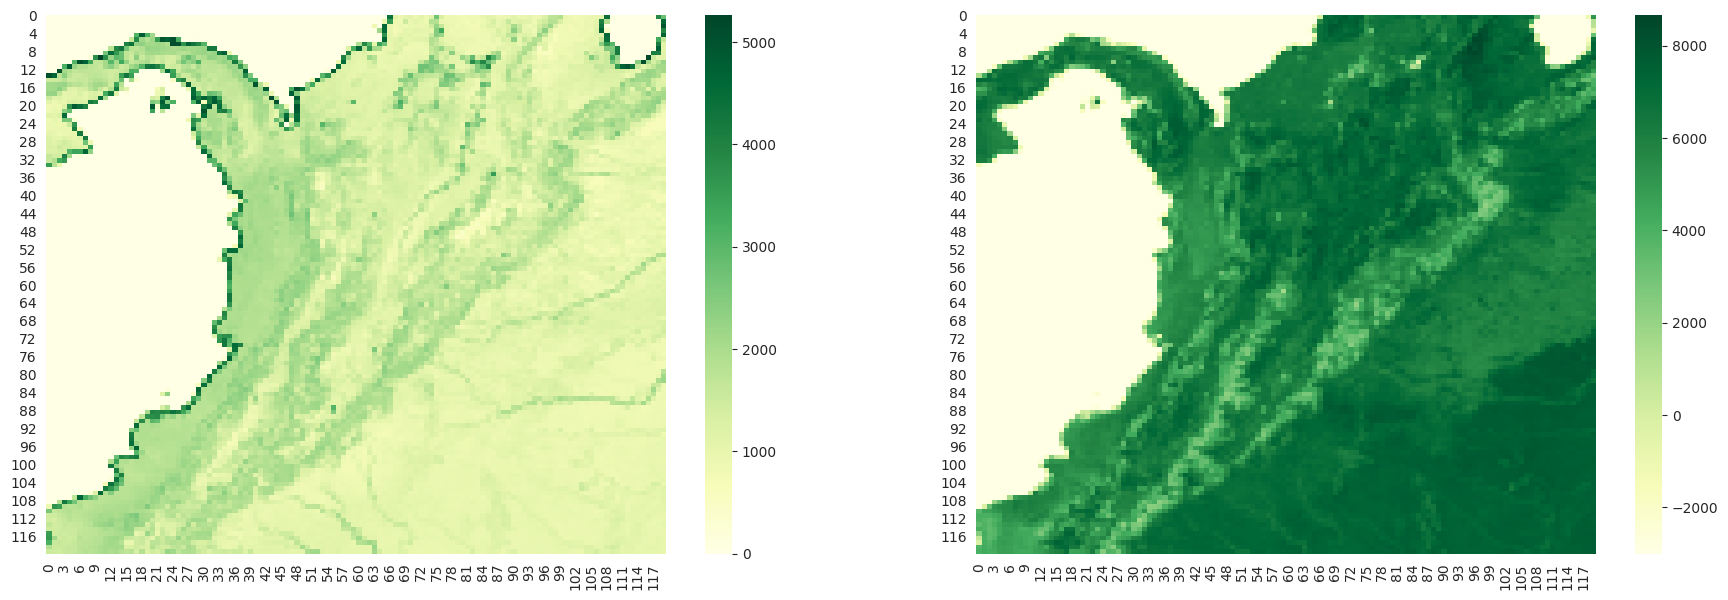

In [172]:
f, ax = plt.subplots(1,2, figsize=[22,7])
sns.heatmap(data=mean_stddev, ax=ax[0], cmap='YlGn',)
sns.heatmap(data=mean_mean, ax=ax[1], cmap='YlGn',)

In [173]:
"""
https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/modis-overview/
MODIS Metadata
MODIS products have two sources of metadata: the embedded HDF metadata, and the external ECS metadata. The HDF metadata contains valuable information including global attributes and dataset specific attributes pertaining to the granule. The structure of this metadata is broadly similar to that of an ASTER HDF file. The ECS (generated by the EOSDIS Core System) .met file is the external metadata file in XML format, which is delivered to the user along with the MODIS product. It provides a subset of the HDF metadata. Some key features of certain MODIS metadata attributes include the following:

The Xdim and Ydim represent the rows and columns of the data, respectively
The Projection and ProjParams identify the projection and its corresponding projection parameters
The Sinusoidal Projection is used for most of the gridded MODIS land products, and has a unique sphere measuring 6371007.181 meters
The UpperLeftPointMtrs is in projection coordinates, and identifies the very upper left corner of the upper left pixel of the image data
The LowerRightMtrs identifies the very lower right corner of the lower right pixel of the image data. These projection coordinates are the only metadata that accurately reflect the extreme corners of the gridded image
There are additional BOUNDINGRECTANGLE and GRINGPOINT fields within the metadata, which represent the latitude and longitude coordinates of the geographic tile corresponding to the data
"""

# Read global attribute.
path='/content/drive/MyDrive/propane/data/MOD13Q1.A2000049.h10v08.061.2020041152607.hdf'
# path='/content/drive/MyDrive/propane/data/MOD13Q1.A2000049.h11v08.061.2020041152621.hdf'
hdf = SD(path, SDC.READ)

"""
TODO:
- model vs both mean and median, high, low, and stddev ndvi
"""
fattrs = hdf.attributes(full=1)
ga = fattrs["StructMetadata.0"]
gridmeta = ga[0]
gridmeta

# Construct the grid.  The needed information is in a global attribute
# called 'StructMetadata.0'.  Use regular expressions to tease out the
# extents of the grid.
ul_regex = re.compile(r'''UpperLeftPointMtrs=\(
                            (?P<upper_left_x>[+-]?\d+\.\d+)
                            ,
                            (?P<upper_left_y>[+-]?\d+\.\d+)
                            \)''', re.VERBOSE)
matched = ul_regex.search(gridmeta)
x0 = np.float64(matched.group('upper_left_x'))
y0 = np.float64(matched.group('upper_left_y'))

lr_regex = re.compile(r'''LowerRightMtrs=\(
                            (?P<lower_right_x>[+-]?\d+\.\d+)
                            ,
                            (?P<lower_right_y>[+-]?\d+\.\d+)
                            \)''', re.VERBOSE)
matched = lr_regex.search(gridmeta)
x1 = np.float64(matched.group('lower_right_x'))
y1 = np.float64(matched.group('lower_right_y'))
ny, nx = mean_qa.shape
xinc = (x1 - x0) / nx
yinc = (y1 - y0) / ny

x = np.linspace(x0, x0 + xinc*nx, nx)
y = np.linspace(y0, y0 + yinc*ny, ny)
xv, yv = np.meshgrid(x, y)

# In basemap, the sinusoidal projection is global, so we won't use it.
# Instead we'll convert the grid back to lat/lons.
sinu = pyproj.Proj("+proj=sinu +R=6371007.181 +nadgrids=@null +wktext")
wgs84 = pyproj.Proj("+init=EPSG:4326")
lon, lat= pyproj.transform(sinu, wgs84, xv, yv)
lon.min(), lon.max(), lat.min(), lat.max()

(-81.23412894333774, -69.99999999371678, 0.0, 9.999999999104968)

## Colombia Overlay

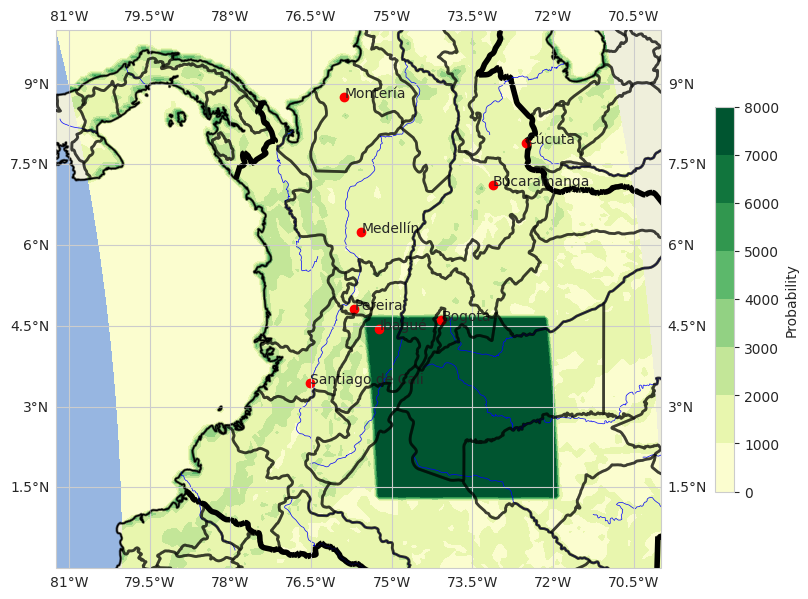

In [174]:
plot_contour(
    cities=cities,
    data_base=mean_stddev,
    data_learned=8000,
    data=mean_stddev,
    lat=lat,
    lon=lon,
    start_lat=start_lat,
    stop_lat=stop_lat,
    start_lon=start_lon,
    stop_lon=stop_lon,
    )

## time series

In [175]:
# ndvi[np.argwhere(mean_qa > 0.5), 2, :].shape
# cleanest = np.argwhere(mean_qa > 0.5)
# print(f"cleanest.shape: {cleanest.shape}")
# rows = np.random.choice(a=np.arange(cleanest.shape[0]), size=10, replace=False)
# for row in rows:
#     i,j = cleanest[row,0], cleanest[row,1]
#     n=y_std[i, j, :, 0, 0]
#     X = X_propane[i, j, :, 0, 0]
#     print(f"n.shape: {n.shape}")
#     plt.figure(figsize=[22,4])
#     plt.plot(n, label='ndvi')
#     plt.plot(X, label='propane')
#     plt.axhline(0, ls='--', color='k', alpha=0.3, lw=4)
#     plt.legend()
#     plt.show()

In [176]:
print(f"X_fourier.shape: {X_fourier.shape}")
print(f"X_data.shape: {X_data.shape}")
print(f"changepoints.shape: {changepoints.shape}")
print(f"I_data.shape: {I_data.shape}")

X_fourier.shape: (40, 40, 109, 1, 8)
X_data.shape: (40, 40, 109, 3, 1)
changepoints.shape: (1, 1, 1, 3, 3)
I_data.shape: (40, 40, 109, 3, 3)


In [177]:
jd = get_joint_distribution(
        X_fourier=X_fourier,
        X_data=X_data,
        changepoints=changepoints,
        I_data=I_data,
        n_blocks_per_row=n_blocks_per_row,
        n_vars=X_data.shape[3],
)
jd

<tfp.distributions.JointDistributionNamed 'JointDistributionNamed' batch_shape=[] event_shape={b0: [40, 40, 1, 3, 1], b0_prior: [1, 1, 1, 3, 1], b1: [40, 40, 1, 3, 1], b1_prior: [1, 1, 1, 3, 1], b2: [40, 40, 1, 3, 3], b2_prior: [1, 1, 1, 3, 3], b_fourier: [40, 40, 1, 1, 8], error: [40, 40, 1, 1, 1], fourier_weights_prior: [], y: [40, 40, 109, 1, 1]} dtype={b0: float32, b0_prior: float32, b1: float32, b1_prior: float32, b2: float32, b2_prior: float32, b_fourier: float32, error: float32, fourier_weights_prior: float32, y: float32}>

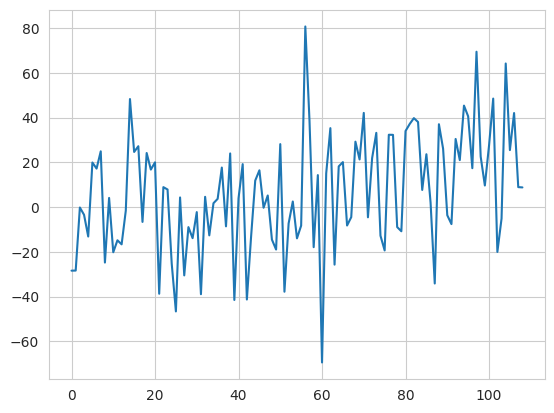

In [178]:
jd.resolve_graph()
prior_predictive = jd.sample()
prior_predictive.keys()
prior_predictive['y'].shape

plt.plot(prior_predictive['y'][0,0,:,0,0].numpy())

In [179]:
jd.log_prob(prior_predictive)

<tf.Tensor: shape=(), dtype=float32, numpy=-654902.75>

In [180]:
params = [p for p in prior_predictive.keys() if 'y' not in p]
print(f"params: {params}")
print(f"len(params): {len(params)}")

params: ['fourier_weights_prior', 'b_fourier', 'b0_prior', 'b0', 'b1_prior', 'b1', 'b2_prior', 'b2', 'error']
len(params): 9


In [181]:
n_chains = 4
n_samples = 200
sample = jd.sample(n_chains)
sample
del sample['y']
sample.keys()
init_state = [
    tf.zeros_like(samp)
    if ('prior' not in param) & ('error' not in param)
    else tf.ones_like(samp)
    for param, samp in sample.items()
    ]

step_size = [tf.cast(i, dtype=tf.float32) for i in np.ones(len(init_state))]
unconstraining_bijectors = [
    tfb.Identity()
    if ('prior' not in param) & ('error' not in param)
    else tfb.Exp()
    for param in sample.keys()
    ]

jd_pinned = jd.experimental_pin(
    y=y_std
)
target_log_prob_fn = jd_pinned.unnormalized_log_prob

# Train

In [182]:
# path = '/content/drive/MyDrive/propane/samples_upper_left.pickle'
path = '/content/drive/MyDrive/propane/samples_lower_right.pickle'
# path = '/content/drive/MyDrive/propane/samples.pickle'

In [ ]:
start = datetime.datetime.now(pytz.timezone("US/Mountain"))
print(f"start: {start}")

samples, sampler_stat = run_chain(
    init_state=init_state,
    step_size=step_size,
    target_log_prob_fn=target_log_prob_fn,
    unconstraining_bijectors=unconstraining_bijectors,
    num_steps=n_samples,
    burnin=200,
    )

end = datetime.datetime.now(pytz.timezone("US/Mountain"))
print(f"training time: {end - start}")
print(f"len(samples): {len(samples)}")
print(f"samples[1].shape: { samples[1].shape }")

# save
with open(path, 'wb') as f:
    pickle.dump(samples, f)

start: 2024-08-14 16:10:57.350180-06:00


# Posterior

In [ ]:
jd = get_joint_distribution(
        X_fourier=X_fourier,
        X_data=X_data,
        changepoints=changepoints,
        I_data=I_data,
        n_blocks_per_row=n_blocks_per_row,
        n_vars=X_data.shape[3],
)


with open(path, 'rb') as f:
    samples = pickle.load(f)

In [ ]:
dir(jd)
parameter_names = [name for name in jd.parameters['model'].keys() if 'y' not in name]
post = {param: sample for param, sample in zip(parameter_names, samples)}

for i, sample in enumerate(samples):
    print(f"i: {i} {parameter_names[i]} sample.shape: { sample.shape }")

In [ ]:
for chain_idx in range(4):
    plt.plot(samples[7][:, chain_idx, 5, 5, 0, var_2_idx['propane_ahead_4'], 0])

In [ ]:
for param, sample in zip(parameter_names, samples):
    if "prior" in param:
        p = 'prior'
    else:
        p = 'no'
    print(f"{p}\t{param}.shape: {sample.shape}")


In [ ]:
# n_blocks short for n_blocks_per_row
# shape = (n_samples, n_blocks, n_blocks, n_timeperiods, n_vars, n_changepoints)
chunks=[-1, 1, 1, -1, -1, -1]

post = get_post(
    jd=jd,
    samples=samples,
    n_samples=n_samples,
    n_chains=n_chains,
    chunks=chunks,
    )

## analysis

In [ ]:
chunks=[-1, 1, 1, -1, -1, -1]
contribution, intercept, slope = get_piecewise_posterior(
    b0=post['b0'],
    b1=post['b1'],
    b2=post['b2'],
    I_data=I_data,
    changepoints=changepoints,
    X_data=X_data,
    chunks=chunks,
)
print(f"post.keys: {post.keys()}")
print(f"contribution.shape: {contribution.shape}")
print(f"slope.shape: {slope.shape}")
print(f"intercept.shape: {intercept.shape}")

In [ ]:
slope_mean = (
    slope[:, :, :, :, var_2_idx['propane_ahead_4'], :]
    .mean(axis=0, keepdims=True) # across samples
    .mean(axis=3, keepdims=True) # across time
).compute()
print(f"slope_mean.mean(): {slope_mean.mean():.4f}")
plt.hist(slope_mean.flatten(), bins=50)
plt.axvline(0, ls='--', color='k', alpha=0.3, lw=4)
plt.show()

In [ ]:
slope_positive = (
    (slope[:, :, :, :,  var_2_idx['propane_ahead_4'], :].compute() > 0)
    .mean(axis=0, keepdims=True) # across samples
    .mean(axis=3, keepdims=True) # across time
)
slope_positive.shape

## contour map

In [ ]:
data = slope_positive.copy()

plot_contour(
    y=0.67,
    cities=cities,
    data_base=y_data.squeeze()[:,:,0],
    data_learned=data.squeeze(),
    data=y_data.squeeze()[:,:,0],
    lat=lat,
    lon=lon,
    start_lat=start_lat,
    stop_lat=stop_lat,
    start_lon=start_lon,
    stop_lon=stop_lon,

    title="When LPG ↓ Does Deforestation ↑",
    levels=np.concatenate([
        np.zeros(1),
        np.arange(
            start=0.51,
            stop=np.max(slope_positive),
            step=0.05,
            )])
    )

In [ ]:
post_mean = {
    param: sample.mean(axis=0)
    for param, sample in post.items()
    }
contribution_mean, intercept_mean, slope_mean = get_piecewise_posterior(
    b0=post_mean['b0'],
    b1=post_mean['b1'],
    b2=post_mean['b2'],
    I_data=I_data,
    changepoints=changepoints,
    X_data=X_data,
    chunks=chunks,
)

seasonal_mean = (post_mean['b_fourier'] * X_fourier.numpy()).sum(axis=4, keepdims=True).compute()

print(f"var_2_idx: {var_2_idx}")
print(f"contribution_mean.shape: {contribution_mean.shape}")
print(f"slope_mean.shape: {slope_mean.shape}")
print(f"intercept_mean.shape: {intercept_mean.shape}")
print(f"seasonal_mean.shape: {seasonal_mean.shape}")

## curves

In [ ]:
i,j=np.random.choice(np.arange(10), size=1)[0],np.random.choice(np.arange(10), size=1)[0]
print(f"i: {i}, j: {j}")

# X: fourier components, piecewise_vars = trend, clouds, rain, heat, propane
f, ax = plt.subplots(2, 2, figsize=[22,12])
for var_idx in range(len(vars)):
    # if idx_2_var[var_idx] != 'clouds':
        df = pd.DataFrame({
            'data':X_data[i,j,:,var_idx,0],
            'contribution':contribution_mean[0, i,j,:,var_idx,0],
            }).sort_values(['data'])
        ax[0,0].plot(df['data'], df['contribution'], ls='-', alpha=0.8, label=idx_2_var[var_idx])
ax[0,0].legend()

ax[0,1].plot(y_std[i,j,:,0,0], alpha=0.5, lw=4, color='k', label='actual')
ax[0,1].plot(seasonal_mean[i,j,:,0,0], label='seasonal')

var = 'propane_ahead_4'
ax[0,1].plot(X_data[i,j,:,var_2_idx[var],0], alpha=0.5, label=var)
# var = 'heat'
# ax[1].plot(X_data[i,j,:,var_2_idx[var],0], alpha=0.5, label=var)
ax[0,1].legend();

ax[1,0].plot(y_std[i,j,:,0,0], alpha=0.5, lw=4, color='k', label='actual')
ax[1,0].plot(seasonal_mean[i,j,:,0,0], label='seasonal')
ax[1,0].plot(contribution_mean[0, i,j,:,var_2_idx['trend'],0], alpha=0.7, label='trend')
ax[1,0].plot(contribution_mean[0, i,j,:,var_2_idx['propane_ahead_4'],0], alpha=0.7, label='propane_ahead_4')

ax[1,0].legend()

slope_estimates = slope[:, i, j, 0, var_2_idx['propane_ahead_4'], :].compute().flatten()
ax[1,1].set_title(f"slope > 0: {(slope_estimates>0).mean():.4f}")
ax[1,1].hist(slope_estimates, bins=100);

# TODO

In [ ]:
#------------------------------------------------------------------------------
# TODO
#------------------------------------------------------------------------------
# get hpd instead of mean for agg
# get accuracy stats

# model without cloud for comparison
# y: use median, lower or upper, or stddev

# y: biomass use?

#------------------------------------------------------------------------------
# DONE
#------------------------------------------------------------------------------
# get mean slope stats
# loosen priors
# loosen scale prior
# add intercept, not needed because the mean will be zero for all blocks with fixed standardization
# need to lag propane demand?
# adjust the area mask and the mean and stddev calcs to use the mean and std for each block